Anomalies per year:
 year
2023    192
2024    293
Name: is_anomaly, dtype: int64


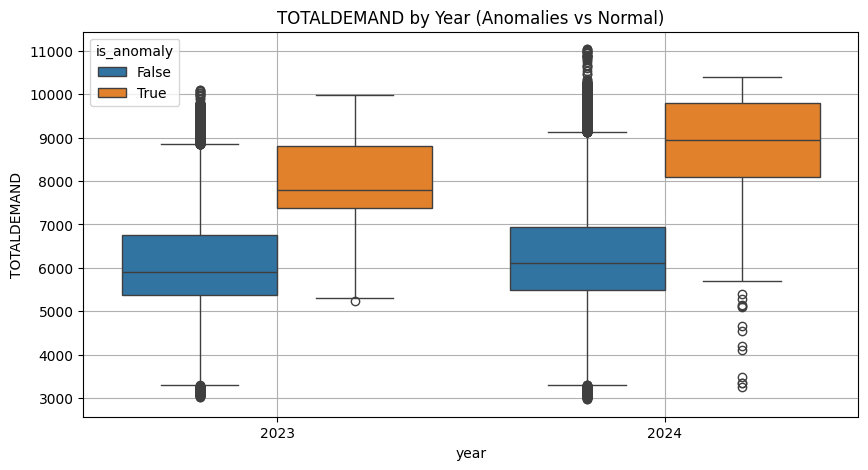

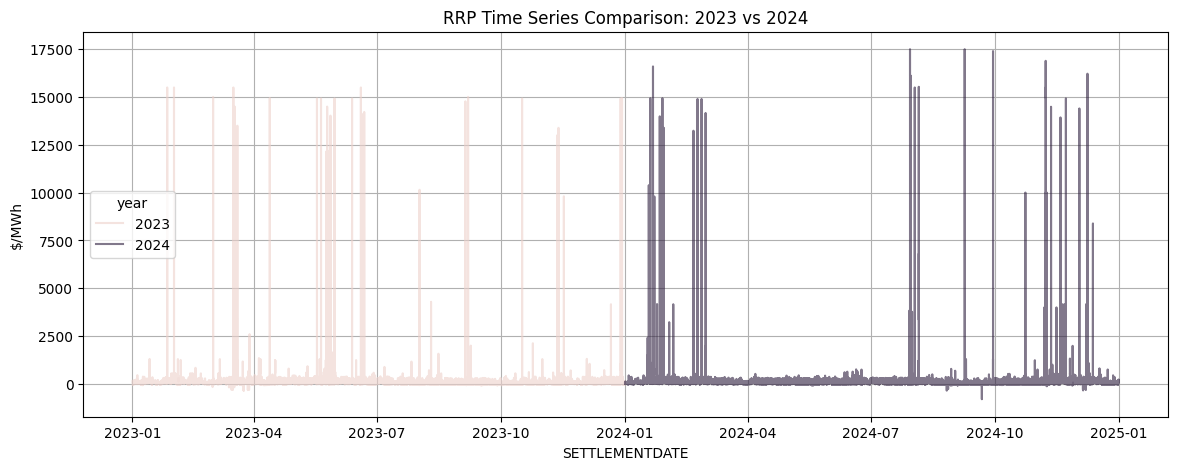

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

price_dir_2023 = "dispatchprice_2023"
demand_dir_2023 = "dispatchregionsum_2023"
price_dir_2024 = "dispatchprice_2024"
demand_2024_file = "QLD_DISPATCHREGIONSUM_2024_CLEANED.csv"

# === Column Indices Based on Raw Line Structure ===
IDX_SETTLEMENTDATE = 4
IDX_REGIONID = 6
IDX_RRP = 9
IDX_INTERVENTION = 5
IDX_ROP = 11
IDX_PRICE_STATUS = 36

IDX_TOTALDEMAND = 9
IDX_AVAILABLEGENERATION = 10
IDX_INTERCONNECTORFLOWS = 15

# ========================
# 🔹 1. Clean DISPATCHPRICE (2023)
# ========================
def clean_dispatchprice(folder):
    data = []
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        with open(path, 'r') as f:
            for line in f:
                if line.startswith("D,DISPATCH,PRICE"):
                    parts = line.strip().split(',')
                    if len(parts) > IDX_PRICE_STATUS and parts[IDX_REGIONID] == 'QLD1':
                        try:
                            data.append({
                                "SETTLEMENTDATE": datetime.strptime(parts[IDX_SETTLEMENTDATE].strip('"'), "%Y/%m/%d %H:%M:%S"),
                                "REGIONID": parts[IDX_REGIONID],
                                "RRP": float(parts[IDX_RRP]),
                                "ROP": float(parts[IDX_ROP]),
                                "INTERVENTION": int(parts[IDX_INTERVENTION]),
                                "PRICE_STATUS": parts[IDX_PRICE_STATUS].strip('"')
                            })
                        except:
                            continue
    return pd.DataFrame(data)

df_price_2023 = clean_dispatchprice(price_dir_2023)
df_price_2023["year"] = 2023

# ========================
# 🔹 2. Detect Anomalies (2023)
# ========================
df_price_2023["is_anomaly"] = (df_price_2023["RRP"] > 1000) | (df_price_2023["RRP"] < -100)

# ========================
# 🔹 3. Clean DISPATCHREGIONSUM (2023)
# ========================
def clean_dispatchregionsum(folder):
    data = []
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        with open(path, 'r') as f:
            for line in f:
                if line.startswith("D,DISPATCH,REGIONSUM"):
                    parts = line.strip().split(',')
                    if len(parts) > IDX_INTERCONNECTORFLOWS and parts[IDX_REGIONID] == 'QLD1':
                        try:
                            data.append({
                                "SETTLEMENTDATE": datetime.strptime(parts[IDX_SETTLEMENTDATE].strip('"'), "%Y/%m/%d %H:%M:%S"),
                                "REGIONID": parts[IDX_REGIONID],
                                "TOTALDEMAND": float(parts[IDX_TOTALDEMAND]),
                                "AVAILABLEGENERATION": float(parts[IDX_AVAILABLEGENERATION]),
                                "INTERCONNECTORFLOWS": float(parts[IDX_INTERCONNECTORFLOWS])
                            })
                        except:
                            continue
    return pd.DataFrame(data)

df_demand_2023 = clean_dispatchregionsum(demand_dir_2023)

# ========================
# 🔹 4. Merge Price + Demand (2023)
# ========================
df_merged_2023 = pd.merge(df_price_2023, df_demand_2023, on="SETTLEMENTDATE", how="inner")

# ========================
# 🔹 5. Load and Prepare 2024 Merged Data
# ========================
df_price_2024 = pd.read_csv("QLD_DISPATCHPRICE_2024_CLEANED_FULL.csv", parse_dates=["SETTLEMENTDATE"])
df_price_2024["is_anomaly"] = (df_price_2024["RRP"] > 1000) | (df_price_2024["RRP"] < -100)
df_demand_2024 = pd.read_csv(demand_2024_file, parse_dates=["SETTLEMENTDATE"])
df_merged_2024 = pd.merge(df_price_2024, df_demand_2024, on="SETTLEMENTDATE", how="inner")
df_merged_2024["year"] = 2024

# ========================
# 🔹 6. Combine 2023 + 2024
# ========================
combined = pd.concat([df_merged_2023, df_merged_2024], ignore_index=True)

# ========================
# 📈 7. Visualisations
# ========================

# Anomaly frequency
anomaly_counts = combined.groupby("year")["is_anomaly"].sum()
print("Anomalies per year:\n", anomaly_counts)

# Compare demand during anomalies
plt.figure(figsize=(10,5))
sns.boxplot(data=combined, x="year", y="TOTALDEMAND", hue="is_anomaly")
plt.title("TOTALDEMAND by Year (Anomalies vs Normal)")
plt.grid()
plt.show()

# Compare price trends
plt.figure(figsize=(14,5))
sns.lineplot(data=combined, x="SETTLEMENTDATE", y="RRP", hue="year", alpha=0.6)
plt.title("RRP Time Series Comparison: 2023 vs 2024")
plt.ylabel("$/MWh")
plt.grid()
plt.show()


Monthly Average Comparison


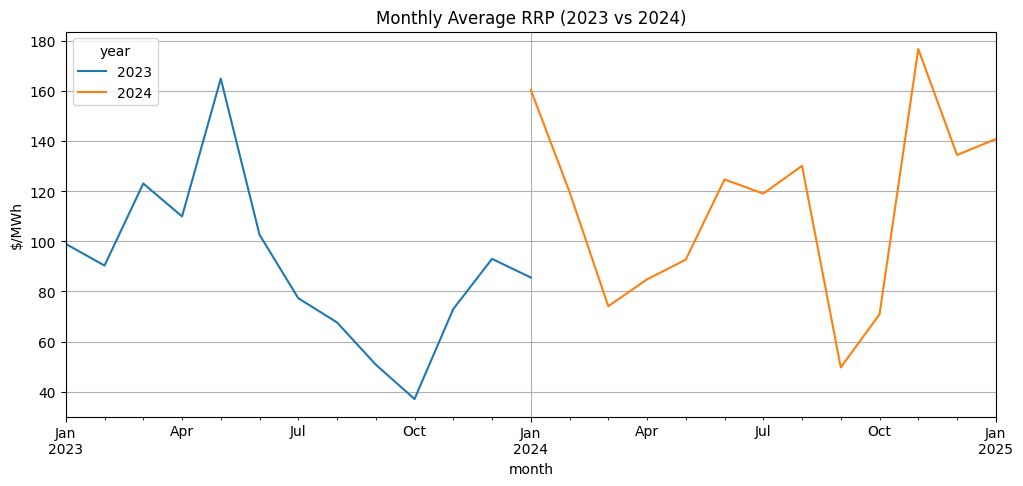

In [3]:
combined["month"] = combined["SETTLEMENTDATE"].dt.to_period("M")
monthly_avg = combined.groupby(["year", "month"])["RRP"].mean().unstack(0)

monthly_avg.plot(figsize=(12,5), title="Monthly Average RRP (2023 vs 2024)")
plt.ylabel("$/MWh")
plt.grid()
plt.show()


Combine 2023 and 2024 data


In [4]:
# add year column

In [5]:
df_merged_2023["year"] = 2023
df_merged_2024["year"] = 2024


In [6]:
combined = pd.concat([df_merged_2023, df_merged_2024], ignore_index=True)
combined.to_csv("combined_dispatch_price_demand_2023_2024.csv", index=False)
